<a href="https://colab.research.google.com/github/Rok-sana/ML-course/blob/main/Homework_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (train_test_split,
                                     KFold,
                                     cross_val_score,
                                     GridSearchCV)

from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             roc_auc_score,
                             r2_score,
                             accuracy_score,
                             confusion_matrix,
                             classification_report,
                             mutual_info_score,
                             f1_score)

from sklearn import preprocessing

from sklearn.preprocessing import(MinMaxScaler,
                                  StandardScaler,
                                  LabelEncoder)

from sklearn.neighbors import KNeighborsClassifier
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import Rank2D

In [ ]:
df = pd.read_csv('abalone.data', header=None, prefix="X")
df.columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
                        'Shucked weight', 'Viscera weight', 'Shell weight',
                        'Rings']



In [ ]:
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [ ]:
df.dtypes

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
Rings               int64
dtype: object

In [ ]:
df.isnull().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

In [ ]:
 df.Sex.value_counts(dropna=False)

M    1528
I    1342
F    1307
Name: Sex, dtype: int64

In [ ]:
sex_dictionary = {'M': 1, 'F' : 2,'I':3}
df['Sex'] = df['Sex'].apply(lambda x: sex_dictionary[x])

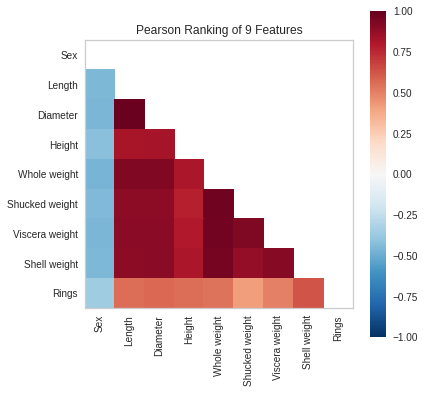

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
pcv = Rank2D(features=df.columns, algorithm="pearson")
pcv.fit(df, df.Rings)
pcv.transform(df)
pcv.poof()

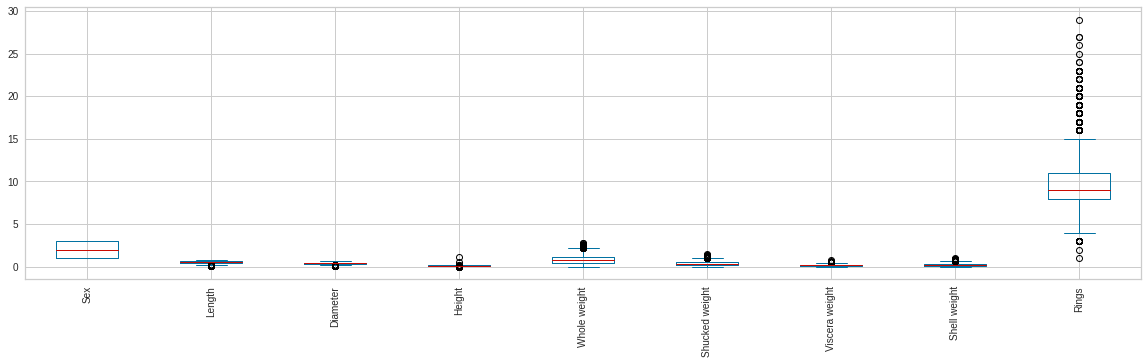

In [ ]:
df.plot.box(figsize=(20,5), rot=90)

Rings 1-8 -->Age 1, denoting young

Rings 9-10 -->Age 2, denoting middle

Rings 11-29 -->Age 3, denoting old

In [ ]:
def calculate_age_category(row):
   if row['Rings']>=1 and row['Rings']<=8:
      return 1
   elif row['Rings'] >=9 and row['Rings']<=10:
      return 2
   elif row['Rings']>=11 and row['Rings']<=29:
      return 3
   return 0

In [ ]:
df['Age_category']=df.apply (lambda row: calculate_age_category(row),axis=1)
df.Sex = df.Sex.astype(float)

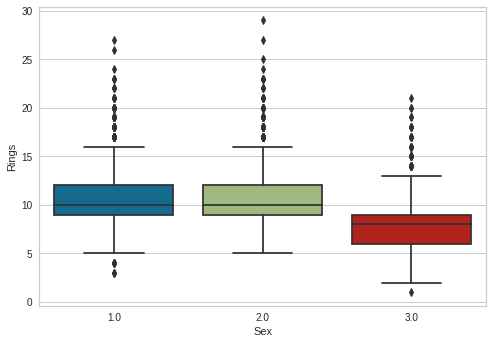

In [ ]:
ax = sns.boxplot(x="Sex", y="Rings", data=df)
plt.show()

Infants have lower number of rings as compared to males and females

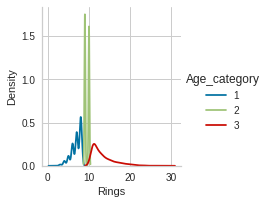

In [ ]:
sns.FacetGrid(df, hue="Age_category") \
   .map(sns.kdeplot, "Rings") \
   .add_legend()
  

Age labelled 1 are youth, label 2 are middle aged and 3 are old aged. Young abalones have 0-8 rings, Middle aged abalones have 9-10 rings and old abalones have more than 11 rings

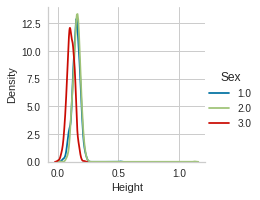

In [ ]:
sns.FacetGrid(df, hue="Sex") \
   .map(sns.kdeplot, "Height") \
   .add_legend()


In [ ]:
def correlated_columns(df, threshold=0.95):
  return (df.corr().pipe(
      lambda df1: pd.DataFrame(
            np.tril(df1, k=-1),
            columns=df.columns,
            index=df.columns,))
  .stack()
  .rename("pearson")
  .pipe(
      lambda s: s[s.abs() > threshold].reset_index())
  .query("level_0 not in level_1"))

In [ ]:
c_df = correlated_columns(df)
c_df.style.format({"pearson": "{:.2f}"})

,level_0,level_1,pearson
0,Diameter,Length,0.99
1,Shucked weight,Whole weight,0.97
2,Viscera weight,Whole weight,0.97
3,Shell weight,Whole weight,0.96


Remove overcorrelated features

In [ ]:
del df['Shucked weight']
del df['Viscera weight']
del df['Shell weight']
del df['Length']

In [ ]:
target = 'Age_category'
using_columns = ['Sex', 'Diameter', 'Height', 'Whole weight', 'Age_category']

Because of data isn't normalize and have some outliners we will be use StandardScaler.


In [ ]:
std = preprocessing.StandardScaler()

Preparing df to scalling 

In [ ]:
df = pd.DataFrame(std.fit_transform(df[using_columns]), columns = using_columns)

In [ ]:
X_full_train, X_test = train_test_split(df[using_columns], test_size=0.2, random_state=0)
X_train, X_val = train_test_split(X_full_train, test_size=0.25, random_state=0)

In [ ]:
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [ ]:
y_train = X_train.Age_category
y_val = X_val.Age_category
y_test = X_test.Age_category

del X_train['Age_category']
del X_val['Age_category']
del X_test['Age_category']

In [ ]:
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

In [ ]:
classifier = KNeighborsClassifier(n_neighbors =5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_val)
    
f1_score(y_val, y_pred, average='micro')

0.5478468899521531

In [ ]:
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range, weights=['uniform', 'distance'], algorithm=['auto', 'ball_tree', 'kd_tree', 'brute'])

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
grid = GridSearchCV(knn, param_grid, cv=3, scoring='f1_micro', return_train_score=False,verbose=1)

In [ ]:
grid_search=grid.fit(X_train, y_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


In [ ]:
print(grid_search.best_params_, grid_search.best_score_)

{'algorithm': 'auto', 'n_neighbors': 29, 'weights': 'uniform'} 0.5892215568862276


In [ ]:
y_val_predicted=grid_search.predict(X_val) 

val_f1=f1_score(y_val,y_val_predicted, average='micro')*100

print("F1_score for validation dataset with tuning is : {:.2f}%".format(val_f1) )

F1_score for validation dataset with tuning is : 58.61%


In [ ]:
knn = KNeighborsClassifier(algorithm='auto',n_neighbors=29, weights='uniform')

knn.fit(X_train, y_train)

y_test_predicted=knn.predict(X_test) 

test_f1=f1_score(y_test,y_test_predicted, average='micro')*100

print("F1_score for test dataset with tuning is : {:.2f}%".format(test_f1) )

F1_score for test dataset with tuning is : 61.36%


In [ ]:
confusion_matrix(y_test, y_test_predicted)

array([[232,  54,  21],
       [ 44, 116,  74],
       [ 28, 102, 165]])

In [ ]:
knn.score(X_test, y_test)

0.6136363636363636

Applying LogisticRegression

In [ ]:
C_array = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
tuning_C = {"C": C_array}

In [ ]:
clf_gs =  LogisticRegression(max_iter= 1000000)
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(estimator= clf_gs, param_grid =tuning_C, scoring = 'f1_micro', cv = 2)
gs.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=LogisticRegression(max_iter=1000000),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000]},
             scoring='f1_micro')

In [ ]:
# Optimal C value and the score corresponding to it
print(gs.best_params_, gs.best_score_)

{'C': 10} 0.5720612383315187


In [ ]:
#logistic regression
log_reg = LogisticRegression(C = gs.best_params_["C"], multi_class='multinomial',solver ='newton-cg')
log_reg.fit(X_train, y_train)
y_pred=log_reg.predict(X_test) 


#calculate Confusion Matrix
print("Confusion Matrix")
confusion_matrix(y_test, y_pred)
    
print("Accuracy of Logistic Regression is:{:.2f}%".format(accuracy_score(y_test, y_pred)*100))


#Mean Absolute Error 
mae=mean_absolute_error(y_test,y_pred);
print("MAE:"+str(mae))

Confusion Matrix
Accuracy of Logistic Regression is:61.60%
MAE:0.4342105263157895
